In [2]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

# data prepare

In [3]:
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [4]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 469
==>>> total testing batch number: 79


In [5]:
inputs, _ = next(iter(train_loader))
img = inputs[4][0]

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray', interpolation='nearest')

# MODEL

In [6]:
class generator(nn.Module):

    def __init__(self, input_size=100, output_size = 28*28):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, output_size)

    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        return x

    
class discriminator(nn.Module):

    def __init__(self, input_size=28*28, output_size=1):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_size)

    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x

# Training

In [7]:
G = generator()
D = discriminator()

if use_cuda:
    G = G.cuda()
    D = D.cuda()

G_optimizer = optim.Adam(G.parameters(), lr=0.0002)
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)
criterion = nn.BCELoss()

for epoch in range(1, 60):
    for batch_idx, (x_real, target) in enumerate(train_loader):
        batch_size = x_real.size()[0]
        
        #train D ##################################################
        D_optimizer.zero_grad()
        x_real = x_real.view(-1, 28*28)
        y_real = torch.ones(batch_size)
        y_fake = torch.zeros(batch_size)

        if use_cuda:
            x_real = x_real.cuda()
            y_real = y_real.cuda()
            y_fake = y_fake.cuda()
        x_real, y_real, y_fake = Variable(x_real), Variable(y_real), Variable(y_fake)
        
        result_D = D(x_real)
        D_loss_real = criterion(result_D, y_real)
        
        z = torch.randn((batch_size, 100))
        z = Variable(z.cuda())
        x_fake = G(z)
        result_D = D(x_fake)
        D_loss_fake = criterion(result_D, y_fake)

        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()
        if ((batch_idx+1) == len(train_loader)):
            print('==>>> epoch: {}, batch index: {}, D loss: {:.6f}'.format(
                epoch, batch_idx+1, D_loss.data))
        
        #train G ##############################################
        G_optimizer.zero_grad()
        z = torch.randn((batch_size, 100))
        y_fake = torch.ones(batch_size)
        if use_cuda:
            z = z.cuda()
            y_fake = y_fake.cuda()
        z, y_fake = Variable(z), Variable(y_fake)
        
        x_fake = G(z)
        D_result = D(x_fake)
        G_loss = criterion(D_result, y_fake)
        G_loss.backward()
        G_optimizer.step()
        if ((batch_idx+1) == len(train_loader)):
            print('==>>> epoch: {}, batch index: {}, G loss: {:.6f}'.format(
                epoch, batch_idx+1, G_loss.data))
            
print("Finished! ")

C:\Users\wonbin\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\wonbin\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\wonbin\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\wonbin\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([96])) that i

==>>> epoch: 1, batch index: 469, D loss: 0.051605
==>>> epoch: 1, batch index: 469, G loss: 7.615733
==>>> epoch: 2, batch index: 469, D loss: 0.178058
==>>> epoch: 2, batch index: 469, G loss: 14.843661
==>>> epoch: 3, batch index: 469, D loss: 0.286561
==>>> epoch: 3, batch index: 469, G loss: 3.779575
==>>> epoch: 4, batch index: 469, D loss: 0.422563
==>>> epoch: 4, batch index: 469, G loss: 3.221140
==>>> epoch: 5, batch index: 469, D loss: 0.348860
==>>> epoch: 5, batch index: 469, G loss: 4.446423
==>>> epoch: 6, batch index: 469, D loss: 0.157613
==>>> epoch: 6, batch index: 469, G loss: 5.257874
==>>> epoch: 7, batch index: 469, D loss: 0.212265
==>>> epoch: 7, batch index: 469, G loss: 5.563035
==>>> epoch: 8, batch index: 469, D loss: 0.231228
==>>> epoch: 8, batch index: 469, G loss: 5.570754
==>>> epoch: 9, batch index: 469, D loss: 0.453322
==>>> epoch: 9, batch index: 469, G loss: 3.045223
==>>> epoch: 10, batch index: 469, D loss: 0.406285
==>>> epoch: 10, batch index:

==>>> epoch: 79, batch index: 469, G loss: 0.967399
==>>> epoch: 80, batch index: 469, D loss: 1.130941
==>>> epoch: 80, batch index: 469, G loss: 1.024894
==>>> epoch: 81, batch index: 469, D loss: 1.235416
==>>> epoch: 81, batch index: 469, G loss: 0.890073
==>>> epoch: 82, batch index: 469, D loss: 1.186785
==>>> epoch: 82, batch index: 469, G loss: 1.163166
==>>> epoch: 83, batch index: 469, D loss: 1.175599
==>>> epoch: 83, batch index: 469, G loss: 1.003780
==>>> epoch: 84, batch index: 469, D loss: 1.256184
==>>> epoch: 84, batch index: 469, G loss: 0.948153
==>>> epoch: 85, batch index: 469, D loss: 1.192183
==>>> epoch: 85, batch index: 469, G loss: 1.008269
==>>> epoch: 86, batch index: 469, D loss: 1.262308
==>>> epoch: 86, batch index: 469, G loss: 1.058756
==>>> epoch: 87, batch index: 469, D loss: 1.452893
==>>> epoch: 87, batch index: 469, G loss: 0.878629
==>>> epoch: 88, batch index: 469, D loss: 1.069228
==>>> epoch: 88, batch index: 469, G loss: 1.038922
==>>> epoch:

# Generated image

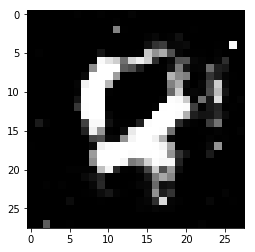

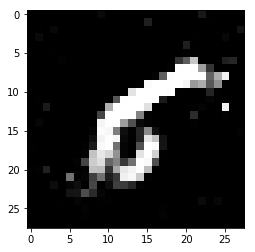

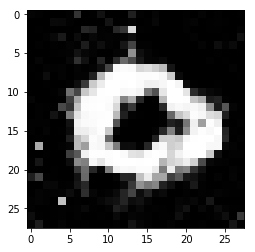

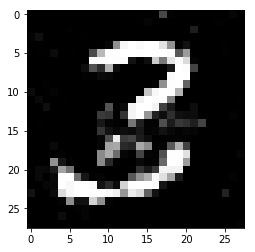

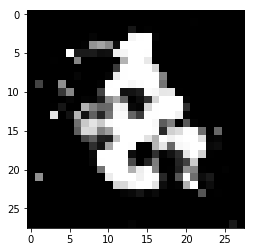

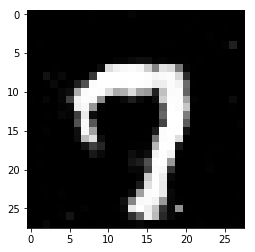

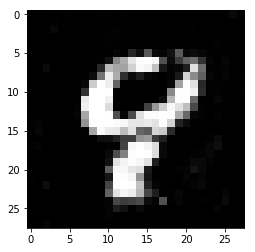

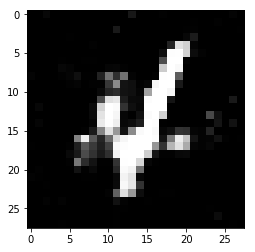

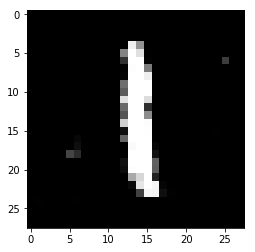

In [8]:
z = (torch.randn((10, 100))).cuda()
fake_img = G(z)

import matplotlib.pyplot as plt
for i in range(1, 10):
    img = fake_img[i].cpu().detach().numpy()
    img = img.reshape(28, 28)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='nearest')